# 初探量化世界
---

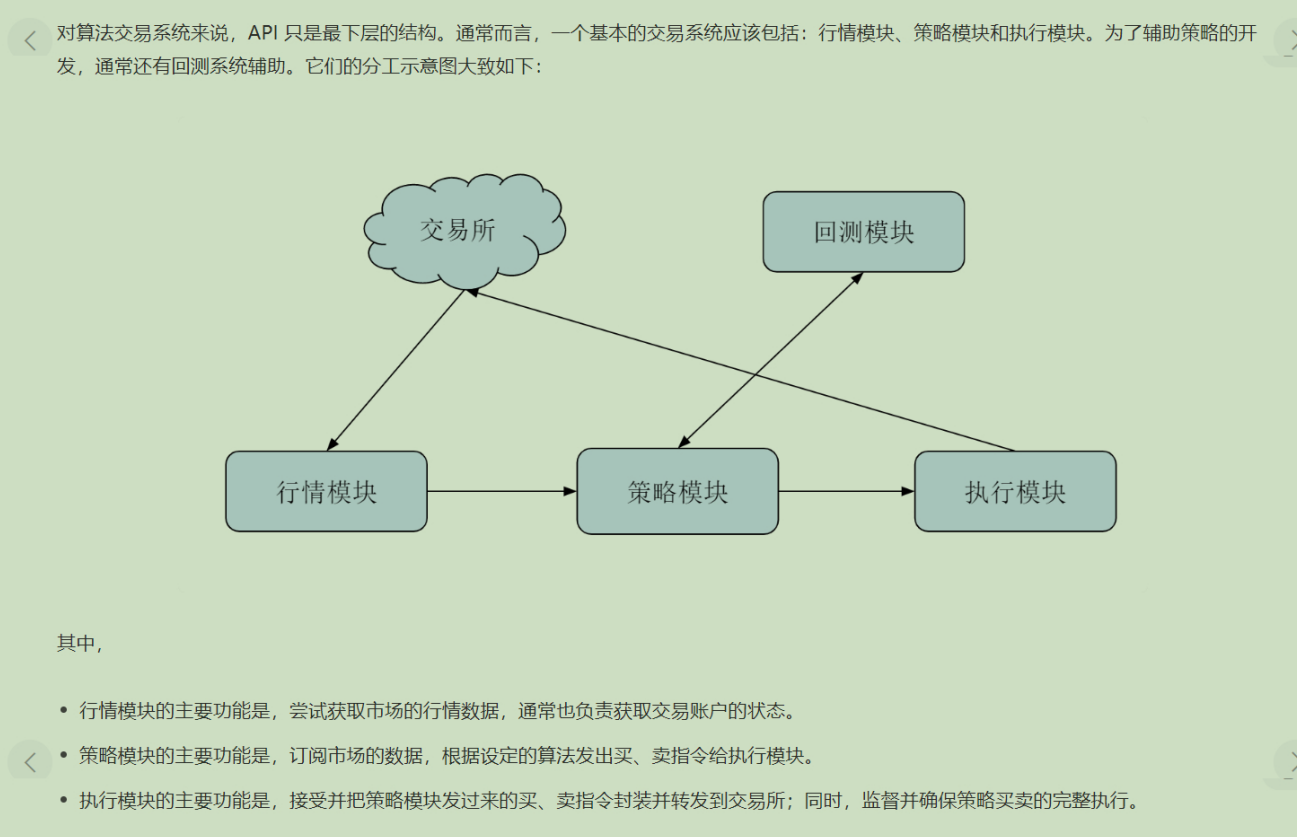

## 比特币过去1小时在Gemini交易所的价格曲线

    CloseTime  OpenPrice  HighPrice  LowPrice  ClosePrice     Volume  \
0  1670522400   16957.94   16989.64  16930.00    16978.43  34.624237   
1  1670526000   16977.69   17275.74  16971.61    17257.17  56.933117   
2  1670529600   17260.00   17292.38  17189.27    17258.59  17.153358   
3  1670533200   17255.98   17292.45  17163.00    17203.64  58.488573   
4  1670536800   17203.64   17224.80  17176.73    17185.88  45.580660   

             NA  
0  5.872173e+05  
1  9.725337e+05  
2  2.958296e+05  
3  1.007833e+06  
4  7.839618e+05  


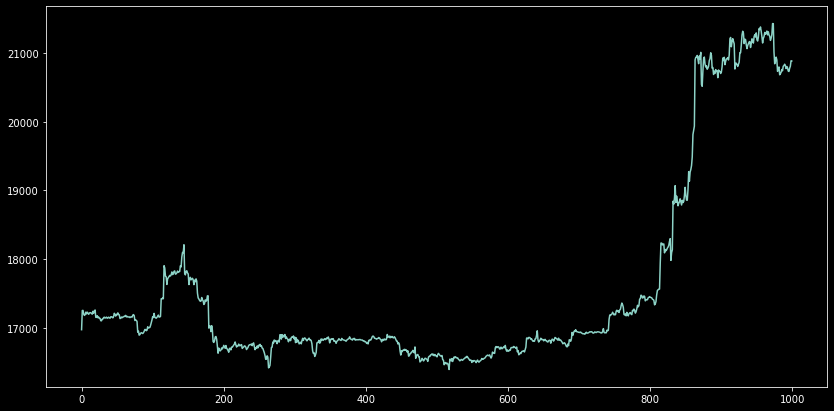

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import requests

# 选择要获取的数据时间段
periods = "3600"

# 通过 Http 抓取 btc 历史价格数据
resp = requests.get(
    "https://api.cryptowat.ch/markets/gemini/btcusd/ohlc", params={"periods": periods}
)
data = resp.json()

# 转换成 pandas data frame
df = pd.DataFrame(
    data["result"][periods],
    columns=[
        "CloseTime",
        "OpenPrice",
        "HighPrice",
        "LowPrice",
        "ClosePrice",
        "Volume",
        "NA",
    ],
)

# 输出 DataFrame 的头部几行
print(df.head())

# 绘制 btc 价格曲线
df["ClosePrice"].plot(figsize=(14, 7))

plt.show()


# RESTful & Socket: 搭建交易执行层核心
---
## REST简介
1. https://www.ruanyifeng.com/blog/2011/09/restful.html
2. https://www.ruanyifeng.com/blog/2014/05/restful_api.html
3. https://www.ruanyifeng.com/blog/2018/10/restful-api-best-practices.html

In [ ]:
import requests
import json
import base64
import hmac
import hashlib
import datetime
import time

base_url = "https://api.sandbox.gemini.com"
endpoint = "/v1/order/new"
url = base_url + endpoint

gemini_api_key = "account-zmidXEwP72yLSSybXVvn"
gemini_api_secret = "375b97HfE7E4tL8YaP3SJ239Pky9".encode()

t = datetime.datetime.now()
payload_nonce = str(int(time.mktime(t.timetuple()) * 1000))

payload = {
    "request": "/v1/order/new",
    "nonce": payload_nonce,
    "symbol": "btcusd",
    "amount": "5",
    "price": "3633.00",
    "side": "buy",
    "type": "exchange limit",
    "options": ["maker-or-cancel"],
}

encoded_payload = json.dumps(payload).encode()
b64 = base64.b64encode(encoded_payload)
signature = hmac.new(gemini_api_secret, b64, hashlib.sha384).hexdigest()

request_headers = {
    "Content-Type": "text/plain",
    "Content-Length": "0",
    "X-GEMINI-APIKEY": gemini_api_key,
    "X-GEMINI-PAYLOAD": b64,
    "X-GEMINI-SIGNATURE": signature,
    "Cache-Control": "no-cache",
}

response = requests.post(url, data=None, headers=request_headers)

new_order = response.json()
print(new_order)


########## 输出 ##########

{
    "order_id": "239088767",
    "id": "239088767",
    "symbol": "btcusd",
    "exchange": "gemini",
    "avg_execution_price": "0.00",
    "side": "buy",
    "type": "exchange limit",
    "timestamp": "1561956976",
    "timestampms": 1561956976535,
    "is_live": True,
    "is_cancelled": False,
    "is_hidden": False,
    "was_forced": False,
    "executed_amount": "0",
    "remaining_amount": "5",
    "options": ["maker-or-cancel"],
    "price": "3633.00",
    "original_amount": "5",
}

# RESTful & Socket：行情数据对接和抓取
---
## Websocket介绍
基于http协议的请求，只是TCP、SSL握手就占据了一半时间。

In [ ]:
import requests
import timeit


def get_orderbook():
    orderbook = requests.get("https://api.gemini.com/v1/book/btcusd").json()


n = 10
latency = (
    timeit.timeit(
        "get_orderbook()", setup="from __main__ import get_orderbook", number=n
    )
    * 1.0
    / n
)
print(f"Latency is {latency * 1000} ms")

###### 输出 #######

# Latency is 196.67642089999663 ms

        Wcurl -w TCP handshake: %{time_connect}s, SSL handshake: %{time_appconnect}s\n" -so /dev/null https://www.gemini.com

        TCP handshake: 0.072758s, SSL handshake: 0.119409W

结果显示，HTTP 连接构建的过程，就占了一大半时间！也就是说，我们每次用 REST 请求，都要浪费一大半的时间在和服务器建立连接上，这显然是非常低效的。很自然的你会想到，我们能否实现一次连接、多次通信呢？

事实上，Python 的某些 HTTP 请求库，也可以支持重用底层的 TCP/SSL 连接。但那种方法，一来比较复杂，二来也需要服务器的支持。该怎么办呢？其实，在有 WebSocket 的情况下，我们完全不需要舍近求远。

我先来介绍一下 WebSocket。WebSocket 是一种在单个 TCP/TLS 连接上，进行全双工、双向通信的协议。WebSocket 可以让客户端与服务器之间的数据交换变得更加简单高效，服务端也可以主动向客户端推送数据。在 WebSocket API 中，浏览器和服务器只需要完成一次握手，两者之间就可以直接创建持久性的连接，并进行双向数据传输。

概念听着很痛快，不过还是有些抽象。为了让你快速理解刚刚的这段话，我们还是来看两个简单的例子。二话不说，先看一段代码：

In [4]:
import websocket
import _thread

# 在接收到服务器发送消息时调用
def on_message(ws, message):
    print(f"Received: {message}")


# 在和服务器建立完成连接时调用
def on_open(ws):
    # 线程运行函数
    def gao():
        # 往服务器依次发送0-4，每次发送完休息0.01秒
        for i in range(5):
            time.sleep(0.01)
            msg = "{0}".format(i)
            ws.send(msg)
            print(f"Sent: {msg}")
        # 休息1秒用于接收服务器回复的消息
        time.sleep(1)

        # 关闭Websocket的连接
        ws.close()
        print("Websocket closed")

    # 在另一个线程运行gao()函数
    _thread.start_new_thread(gao, ())


if __name__ == "__main__":
    ws = websocket.WebSocketApp(
        "ws://echo.websocket.org/", on_message=on_message, on_open=on_open
    )

    ws.run_forever()

#### 输出 #####
# Sent: 0
# Sent: 1
# Received: 0
# Sent: 2
# Received: 1
# Sent: 3
# Received: 2
# Sent: 4
# Received: 3
# Received: 4
# Websocket closed

再来看第二段代码。为了解释”双向“，我们来看看获取 Gemini 的委托账单的例子。

In [6]:
import ssl
import websocket
import json

# 全局计数器
count = 5


def on_message(ws, message):
    global count
    print(message)
    count -= 1
    # 接收了5次消息之后关闭websocket连接
    if count == 0:
        ws.close()


if __name__ == "__main__":
    ws = websocket.WebSocketApp(
        "wss://api.gemini.com/v1/marketdata/btcusd?top_of_book=true&offers=true",
        on_message=on_message,
    )
    ws.run_forever(sslopt={"cert_reqs": ssl.CERT_NONE})

###### 输出 #######
# {"type":"update","eventId":7275473603,"socket_sequence":0,"events":[{"type":"change","reason":"initial","price":"11386.12","delta":"1.307","remaining":"1.307","side":"ask"}]}
# {"type":"update","eventId":7275475120,"timestamp":1562380981,"timestampms":1562380981991,"socket_sequence":1,"events":[{"type":"change","side":"ask","price":"11386.62","remaining":"1","reason":"top-of-book"}]}
# {"type":"update","eventId":7275475271,"timestamp":1562380982,"timestampms":1562380982387,"socket_sequence":2,"events":[{"type":"change","side":"ask","price":"11386.12","remaining":"1.3148","reason":"top-of-book"}]}
# {"type":"update","eventId":7275475838,"timestamp":1562380986,"timestampms":1562380986270,"socket_sequence":3,"events":[{"type":"change","side":"ask","price":"11387.16","remaining":"0.072949","reason":"top-of-book"}]}
# {"type":"update","eventId":7275475935,"timestamp":1562380986,"timestampms":1562380986767,"socket_sequence":4,"events":[{"type":"change","side":"ask","price":"11389.22","remaining":"0.06204196","reason":"top-of-book"}]}

行情抓取模块

In [ ]:
import copy
import json
import ssl
import time
import websocket


class OrderBook(object):

    BIDS = "bid"
    ASKS = "ask"

    def __init__(self, limit=20):

        self.limit = limit

        # (price, amount)
        self.bids = {}
        self.asks = {}

        self.bids_sorted = []
        self.asks_sorted = []

    def insert(self, price, amount, direction):
        if direction == self.BIDS:
            if amount == 0:
                if price in self.bids:
                    del self.bids[price]
            else:
                self.bids[price] = amount
        elif direction == self.ASKS:
            if amount == 0:
                if price in self.asks:
                    del self.asks[price]
            else:
                self.asks[price] = amount
        else:
            print("WARNING: unknown direction {}".format(direction))

    def sort_and_truncate(self):
        # sort
        self.bids_sorted = sorted(
            [(price, amount) for price, amount in self.bids.items()], reverse=True
        )
        self.asks_sorted = sorted(
            [(price, amount) for price, amount in self.asks.items()]
        )

        # truncate
        self.bids_sorted = self.bids_sorted[: self.limit]
        self.asks_sorted = self.asks_sorted[: self.limit]

        # copy back to bids and asks
        self.bids = dict(self.bids_sorted)
        self.asks = dict(self.asks_sorted)

    def get_copy_of_bids_and_asks(self):
        return copy.deepcopy(self.bids_sorted), copy.deepcopy(self.asks_sorted)


class Crawler:
    def __init__(self, symbol, output_file):
        self.orderbook = OrderBook(limit=10)
        self.output_file = output_file

        self.ws = websocket.WebSocketApp(
            "wss://api.gemini.com/v1/marketdata/{}".format(symbol),
            on_message=lambda ws, message: self.on_message(message),
        )
        self.ws.run_forever(sslopt={"cert_reqs": ssl.CERT_NONE})

    def on_message(self, message):
        # 对收到的信息进行处理，然后送给 orderbook
        data = json.loads(message)
        for event in data["events"]:
            price, amount, direction = (
                float(event["price"]),
                float(event["remaining"]),
                event["side"],
            )
            self.orderbook.insert(price, amount, direction)

        # 整理 orderbook，排序，只选取我们需要的前几个
        self.orderbook.sort_and_truncate()

        # 输出到文件
        with open(self.output_file, "a+") as f:
            bids, asks = self.orderbook.get_copy_of_bids_and_asks()
            output = {"bids": bids, "asks": asks, "ts": int(time.time() * 1000)}
            f.write(json.dumps(output) + "\n")


if __name__ == "__main__":
    crawler = Crawler(symbol="BTCUSD", output_file="BTCUSD.txt")

###### 输出 #######

# {"bids": [[11398.73, 0.96304843], [11398.72, 0.98914437], [11397.32, 1.0], [11396.13, 2.0], [11395.95, 2.0], [11395.87, 1.0], [11394.09, 0.11803397], [11394.08, 1.0], [11393.59, 0.1612581], [11392.96, 1.0]], "asks": [[11407.42, 1.30814001], [11407.92, 1.0], [11409.48, 2.0], [11409.66, 2.0], [11412.15, 0.525], [11412.42, 1.0], [11413.77, 0.11803397], [11413.99, 0.5], [11414.28, 1.0], [11414.72, 1.0]], "ts": 1562558996535}
# {"bids": [[11398.73, 0.96304843], [11398.72, 0.98914437], [11397.32, 1.0], [11396.13, 2.0], [11395.95, 2.0], [11395.87, 1.0], [11394.09, 0.11803397], [11394.08, 1.0], [11393.59, 0.1612581], [11392.96, 1.0]], "asks": [[11407.42, 1.30814001], [11407.92, 1.0], [11409.48, 2.0], [11409.66, 2.0], [11412.15, 0.525], [11412.42, 1.0], [11413.77, 0.11803397], [11413.99, 0.5], [11414.28, 1.0], [11414.72, 1.0]], "ts": 1562558997377}
# {"bids": [[11398.73, 0.96304843], [11398.72, 0.98914437], [11397.32, 1.0], [11396.13, 2.0], [11395.95, 2.0], [11395.87, 1.0], [11394.09, 0.11803397], [11394.08, 1.0], [11393.59, 0.1612581], [11392.96, 1.0]], "asks": [[11407.42, 1.30814001], [11409.48, 2.0], [11409.66, 2.0], [11412.15, 0.525], [11412.42, 1.0], [11413.77, 0.11803397], [11413.99, 0.5], [11414.28, 1.0], [11414.72, 1.0]], "ts": 1562558997765}
# {"bids": [[11398.73, 0.96304843], [11398.72, 0.98914437], [11397.32, 1.0], [11396.13, 2.0], [11395.95, 2.0], [11395.87, 1.0], [11394.09, 0.11803397], [11394.08, 1.0], [11393.59, 0.1612581], [11392.96, 1.0]], "asks": [[11407.42, 1.30814001], [11409.48, 2.0], [11409.66, 2.0], [11412.15, 0.525], [11413.77, 0.11803397], [11413.99, 0.5], [11414.28, 1.0], [11414.72, 1.0]], "ts": 1562558998638}
# {"bids": [[11398.73, 0.97131753], [11398.72, 0.98914437], [11397.32, 1.0], [11396.13, 2.0], [11395.95, 2.0], [11395.87, 1.0], [11394.09, 0.11803397], [11394.08, 1.0], [11393.59, 0.1612581], [11392.96, 1.0]], "asks": [[11407.42, 1.30814001], [11409.48, 2.0], [11409.66, 2.0], [11412.15, 0.525], [11413.77, 0.11803397], [11413.99, 0.5], [11414.28, 1.0], [11414.72, 1.0]], "ts": 1562558998645}
# {"bids": [[11398.73, 0.97131753], [11398.72, 0.98914437], [11397.32, 1.0], [11396.13, 2.0], [11395.87, 1.0], [11394.09, 0.11803397], [11394.08, 1.0], [11393.59, 0.1612581], [11392.96, 1.0]], "asks": [[11407.42, 1.30814001], [11409.48, 2.0], [11409.66, 2.0], [11412.15, 0.525], [11413.77, 0.11803397], [11413.99, 0.5], [11414.28, 1.0], [11414.72, 1.0]], "ts": 1562558998748}

# Pandas & Numpy：策略与回测系统
---


In [3]:
%%writefile .\00Pratice\02advanced\test.py
import os.path as path
import pandas as pd

def assert_msg(condition, msg):
    if not condition:
        raise Exception(msg)


def read_file(filename):
    # 获得文件绝对路径
    filepath = path.join(path.dirname(__file__), filename)

    # 判定文件是否存在
    assert_msg(path.exists(filepath), "文件不存在")

    # 读取CSV文件并返回
    return pd.read_csv(
        filepath, index_col=0, parse_dates=True, infer_datetime_format=True
    )


BTCUSD = read_file("BTCUSD_GEMINI.csv")
assert_msg(BTCUSD.__len__() > 0, "读取失败")
print(BTCUSD.head())


########## 输出 ##########
# Time                 Symbol      Open      High       Low     Close     Volume
# Date
# 2019-07-08 00:00:00  BTCUSD  11475.07  11540.33  11469.53  11506.43  10.770731
# 2019-07-07 23:00:00  BTCUSD  11423.00  11482.72  11423.00  11475.07  32.996559
# 2019-07-07 22:00:00  BTCUSD  11526.25  11572.74  11333.59  11423.00  48.937730
# 2019-07-07 21:00:00  BTCUSD  11515.80  11562.65  11478.20  11526.25  25.323908
# 2019-07-07 20:00:00  BTCUSD  11547.98  11624.88  11423.94  11515.80  63.211972

Overwriting .\00Pratice\02advanced\test.py
